[View in Colaboratory](https://colab.research.google.com/github/orid7/Predict_NumOfInstalls/blob/master/Predict_Installs_by_budget_using_ML.ipynb)

# **Maximize app installs by budget allocation across different advertising platforms** 

**Key steps: **

1.  Import history data 
2.  Build Daily data
3. Calculate the total amount of installations per day according to budget allocation
4. Building a regression model - Given the distribution of a budget,The model **Predict what will be the total amount of installations**.

5. Using the Coefficients of the regression model, we have the target function.

6. Now, Given a maximum budget, we can **find the best budget allocation to maximize the amount of installs**




In [0]:
import pandas as pd

import numpy as np
import datetime  
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn import metrics



/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [0]:
%config IPCompleter.greedy=True
%matplotlib inline

In [0]:

url="https://raw.githubusercontent.com/orid7/Predict_NumOfInstalls/master/data_installs.csv"
Data=pd.read_csv(url)

The initial data contains all the historical samples of :

1.   Date
1.  The amount of budget allocated to a particular platform
2.   the amount of installs of the application



In [0]:
 Data = Data.rename(columns={'Country Advertisers Mobile OS': 'Adv',' Installs ':'Installs'})
Data.head()

,Date,Adv,Budget,Installs
0,01/01/2016,EU Facebook Android,564.21,"1,012"
1,01/01/2016,EU Facebook iOS,84.50,102
2,01/01/2016,EU GoogleSearch Android,605.18,"1,721"
3,01/01/2016,EU GoogleSearch iOS,121.78,164
4,01/01/2016,US Facebook Android,"1,666.76",802


**A reminder of the Target function** - we want to maximize the amount of daily installs by dividing the daily budget.

Therefore, we must build a new DataFrame that each row contains the day of the year, the amount of budget allocated to a particular platform on the same day, and the total number of daily installs.

In [0]:
#Build the columns of each platform:
Adv_names=Data.Adv.unique()
f = lambda t: t.replace(" ", "_")
fv=np.vectorize(f)
adv_budget=fv(Adv_names)
adv_installs=adv_budget
f2 = lambda t: t+"_budget"
fv2=np.vectorize(f2)
f3 = lambda t: t+"_installs"
fv3=np.vectorize(f3)
adv_budget=fv2(adv_budget)
adv_installs=fv3(adv_installs)


In [0]:

# Create new DataFrame
columns= ['Date',*adv_budget,*adv_installs,'sum_installs']
df=pd.DataFrame(columns=columns)

df

,Date,EU_Facebook_Android_budget,EU_Facebook_iOS_budget,EU_GoogleSearch_Android_budget,EU_GoogleSearch_iOS_budget,US_Facebook_Android_budget,US_Facebook_iOS_budget,US_GoogleSearch_Android_budget,US_GoogleSearch_iOS_budget,EU_Facebook_Android_installs,EU_Facebook_iOS_installs,EU_GoogleSearch_Android_installs,EU_GoogleSearch_iOS_installs,US_Facebook_Android_installs,US_Facebook_iOS_installs,US_GoogleSearch_Android_installs,US_GoogleSearch_iOS_installs,sum_installs


In [0]:
# A function that receives a row from the initial data, and feeds the data in the appropriate place in the new DataFrame


def build_Dataframe(row):
  Adv1=fv(row.Adv)
  adv_budget_value=fv2(Adv1)[-1]
  adv_installs_value=fv3(Adv1)[-1]
  global df
      
  if(row.Date.values[-1] in df.Date.values):
      index=df.index[df['Date'] == row.Date.values[-1]]
      df[adv_budget_value][index[-1]]=row.Budget.values[-1]
      df[adv_installs_value][index[-1]]=row.Installs.values[-1]
  else:
      emptyRow=pd.DataFrame([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]],columns=columns)
      df=df.append(emptyRow,ignore_index=True)
      df['Date'][df.index[-1]]=row.Date.values[-1]
      df[adv_budget_value][df.index[-1]]=row.Budget.values[-1]
      df[adv_installs_value][df.index[-1]]=row.Installs.values[-1]
      
  return 

In [0]:
#for each row in the initial data, Enter the data to the new DataFrame

for i in range(0, len(Data)):
  build_Dataframe(Data.iloc[[i]])

**Print the new DataFrame:**

In [0]:
df.head()


,Date,EU_Facebook_Android_budget,EU_Facebook_iOS_budget,EU_GoogleSearch_Android_budget,EU_GoogleSearch_iOS_budget,US_Facebook_Android_budget,US_Facebook_iOS_budget,US_GoogleSearch_Android_budget,US_GoogleSearch_iOS_budget,EU_Facebook_Android_installs,EU_Facebook_iOS_installs,EU_GoogleSearch_Android_installs,EU_GoogleSearch_iOS_installs,US_Facebook_Android_installs,US_Facebook_iOS_installs,US_GoogleSearch_Android_installs,US_GoogleSearch_iOS_installs,sum_installs
0,01/01/2016,564.21,84.50,605.18,121.78,"1,666.76","1,657.04","3,018.81",585.53,"1,012",102,"1,721",164,802,529,"1,569",194,0
1,02/01/2016,564.21,83.49,597.26,161.98,"1,666.76","1,655.09","3,005.65",660.37,"1,756",152,"2,046",181,989,715,"1,607",247,0
2,03/01/2016,564.21,83.07,659.30,143.66,"1,666.76","1,657.40","3,015.17",562.44,"1,863",142,"2,319",226,"1,070",684,"1,679",215,0
3,04/01/2016,564.21,82.65,703.16,207.73,"1,666.76","1,650.04","3,169.92",662.92,"1,831",148,"2,661",296,"1,035",663,"1,895",258,0
4,05/01/2016,564.21,83.60,684.17,217.08,"1,666.76","1,782.98","3,173.51",701.79,"1,769",160,"2,522",306,"1,108",800,"1,810",303,0


In [0]:
# Replace all the string columns to numeric
df[cols] = df[cols].applymap(lambda x:float(str(x).replace(',','')))

In [0]:
#Calculates the amount of daily installs by SUM the amount of installations from each platform

df.sum_installs= df.apply(lambda row: row['EU_Facebook_Android_installs'] + row['EU_Facebook_iOS_installs']+row['EU_GoogleSearch_Android_installs']+ row['EU_GoogleSearch_iOS_installs']+ row['US_Facebook_Android_installs']+ row['US_Facebook_iOS_installs']+ row['US_GoogleSearch_Android_installs']+ row['US_GoogleSearch_iOS_installs'], axis=1)

In [0]:
df.head()

,Date,EU_Facebook_Android_budget,EU_Facebook_iOS_budget,EU_GoogleSearch_Android_budget,EU_GoogleSearch_iOS_budget,US_Facebook_Android_budget,US_Facebook_iOS_budget,US_GoogleSearch_Android_budget,US_GoogleSearch_iOS_budget,EU_Facebook_Android_installs,EU_Facebook_iOS_installs,EU_GoogleSearch_Android_installs,EU_GoogleSearch_iOS_installs,US_Facebook_Android_installs,US_Facebook_iOS_installs,US_GoogleSearch_Android_installs,US_GoogleSearch_iOS_installs,sum_installs
0,01/01/2016,564.21,84.50,605.18,121.78,1666.76,1657.04,3018.81,585.53,1012.0,102.0,1721.0,164.0,802.0,529.0,1569.0,194.0,6093.0
1,02/01/2016,564.21,83.49,597.26,161.98,1666.76,1655.09,3005.65,660.37,1756.0,152.0,2046.0,181.0,989.0,715.0,1607.0,247.0,7693.0
2,03/01/2016,564.21,83.07,659.30,143.66,1666.76,1657.40,3015.17,562.44,1863.0,142.0,2319.0,226.0,1070.0,684.0,1679.0,215.0,8198.0
3,04/01/2016,564.21,82.65,703.16,207.73,1666.76,1650.04,3169.92,662.92,1831.0,148.0,2661.0,296.0,1035.0,663.0,1895.0,258.0,8787.0
4,05/01/2016,564.21,83.60,684.17,217.08,1666.76,1782.98,3173.51,701.79,1769.0,160.0,2522.0,306.0,1108.0,800.0,1810.0,303.0,8778.0


In [0]:
#Deletes the amount of installs columns from each platform,
#Because we want to predict the total amount of installations we do not want to put those columns in the regression.

cols_of_interest=['Date',*adv_budget,'sum_installs']
df = df[cols_of_interest]
df.head()

,Date,EU_Facebook_Android_budget,EU_Facebook_iOS_budget,EU_GoogleSearch_Android_budget,EU_GoogleSearch_iOS_budget,US_Facebook_Android_budget,US_Facebook_iOS_budget,US_GoogleSearch_Android_budget,US_GoogleSearch_iOS_budget,sum_installs
0,01/01/2016,564.21,84.50,605.18,121.78,1666.76,1657.04,3018.81,585.53,6093.0
1,02/01/2016,564.21,83.49,597.26,161.98,1666.76,1655.09,3005.65,660.37,7693.0
2,03/01/2016,564.21,83.07,659.30,143.66,1666.76,1657.40,3015.17,562.44,8198.0
3,04/01/2016,564.21,82.65,703.16,207.73,1666.76,1650.04,3169.92,662.92,8787.0
4,05/01/2016,564.21,83.60,684.17,217.08,1666.76,1782.98,3173.51,701.79,8778.0


In [0]:
#Split the data to train column X and the sum of installs - The number that we want to predict as Y

y = np.ravel(df.sum_installs)
cols_of_train=[*adv_budget]
X=df[cols_of_train]


In [0]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

# evaluate the model by splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
regr = linear_model.LinearRegression()

regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, y_pred))





Coefficients: 
 [1.36879584 0.69543647 1.75064041 2.72632398 0.77059904 0.51025889
 0.58922936 0.05530073]
Mean squared error: 835219.87
Variance score: 0.56


In [0]:
pd.DataFrame({'prediction':y_pred ,'Test Values':y_test}).head()

,Test Values,prediction
0,5399.0,6363.400867
1,7723.0,6052.073922
2,4812.0,3524.510558
3,6650.0,6694.863835
4,4819.0,3829.165570


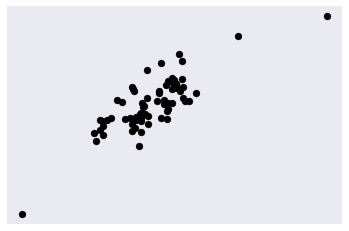

In [0]:
# Plot outputs
plt.scatter(y_pred , y_test,  color='black')
#plt.plot(y_test, y_pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

In [0]:
### Example of how to find max of function:

import numpy as np
from scipy.optimize import fmin
import math


In [0]:
def f1(x):
   
    return -1*math.pow(x,2)+30*x-8

print(f1(2))
  


48.0


In [0]:
max_x = fmin(lambda x: -f1(x), 0)
max_x[0]
print("The budget for x (USA Facebook android) - ", max_x[0])
numInstalls=f1(max_x[0])
print("The number of installs - ", numInstalls)

Optimization terminated successfully.
         Current function value: -217.000000
         Iterations: 33
         Function evaluations: 66
The budget for x (USA Facebook android) -  15.00000000000002
The number of installs -  216.99999999999997
